In [386]:
import glob
import rasterio
import matplotlib.pyplot as plt
import cv2
import numpy as np

## Important

In [387]:
def calculate_black_pixel_percentage(image_array):
    """
    Calculate the percentage of black pixels (intensity 0) in the input image array.

    Args:
        image_array (numpy.ndarray): Grayscale or binary image array.

    Returns:
        percentage (float): Percentage of black pixels in the image.
    """
    if image_array.size == 0:
        return 0.0
    black_pixels = np.count_nonzero(image_array == 0)
    total_pixels = image_array.size
    percentage = (black_pixels / total_pixels) * 100
    return percentage

In [388]:
import numpy as np
from skimage.segmentation import slic
from scipy.ndimage import center_of_mass

def convert_image_array_to_slic_with_properties(image_array, binary_array, n_segments=100, compactness=10, sigma=1):
    """
    Convert an image array to a segmented RGB image using SLIC (Simple Linear Iterative Clustering) algorithm,
    and calculate properties for each superpixel including color, centroid x, centroid y, and number of pixels.

    Args:
        image_array (numpy.ndarray): Input RGB image array.
        binary_array (numpy.ndarray): Binary array of the same dimensions as the image.
        n_segments (int, optional): Number of segments in SLIC. Default is 100.
        compactness (float, optional): Compactness parameter for SLIC. Default is 10.
        sigma (float, optional): Sigma parameter for SLIC. Default is 1.

    Returns:
        segmented_image_rgb (numpy.ndarray): Segmented RGB image.
        properties (numpy.ndarray): Array of dictionaries containing properties for each superpixel.
        labels (numpy.ndarray): Array of labels for each superpixel.
    """
    segments = slic(image_array, n_segments=n_segments, compactness=compactness, sigma=sigma)
    segmented_image_rgb = np.zeros_like(image_array)
    segmented_binary_array=np.zeros_like(binary_array)
    properties = []  # List to store properties
    labels=[]
    
    for segment_id in np.unique(segments):
        mask = segments == segment_id
        segment_rgb = image_array[mask]

        segmented_pixels = binary_array[mask]
        
        
        if np.any(mask):
            num_pixels = np.sum(mask)
            centroid = center_of_mass(mask)
            centroid_x, centroid_y = centroid
            mean_color = np.mean(segment_rgb, axis=0)
            
            mean_color_binary_array=np.bincount(segmented_pixels).argmax()
            

            properties.append({
                'superpixel_num' : segment_id,
                'color': mean_color,  # RGB color values
                'centroid_x': centroid_x,  # x coordinate of centroid
                'centroid_y': centroid_y,  # y coordinate of centroid
                'num_pixels': num_pixels, # number of pixels in superpixel
                'label' : mean_color_binary_array
            })
            labels.append(mean_color_binary_array)

            segmented_image_rgb[mask] = mean_color
            segmented_binary_array[mask]=mean_color_binary_array

    properties = np.array(properties)  # Convert properties list to numpy array
    return segmented_image_rgb, properties, labels, segmented_binary_array,segments

def reverse_segmentation(slic_object,labels):
    segmented_binary_array=np.zeros((512,512))
    for segment_id in np.unique(slic_object):
        mask = slic_object == segment_id
        if np.any(mask):
            segmented_binary_array[mask]=labels[segment_id-1]
        
    return segmented_binary_array

loading true images

In [389]:
# For images
path_to_folders_images = "Natural_False_Color/"
true_dataset = []

tif_files = glob.glob(path_to_folders_images + "*.TIF")

# Iterate through the .tif files and read them using rasterio
for tif_file in tif_files:
    temp=rasterio.open(tif_file)
    red_band = temp.read(1)
    green_band = temp.read(2)
    blue_band = temp.read(3)
    temp.close()
    true = np.stack((red_band, green_band, blue_band), axis=-1)
    true_dataset.append(true)
    

# For labels
path_to_folders_labels = "Entire_scene_gts/"
label_dataset = []

tif_files = glob.glob(path_to_folders_labels + "*.TIF")

# Iterate through the .tif files and read them using rasterio
for tif_file in tif_files:
    temp=rasterio.open(tif_file)
    label = temp.read(1)
    temp.close()
    label_dataset.append(label)
     
        
        
# making patches
patch_size = 512
num_rows = 16
num_cols = 15

true_patches = []
label_patches = []

for i in range(len(true_dataset)):
    for row in range(num_rows):
        for col in range(num_cols):
            start_row = row * patch_size
            end_row = start_row + patch_size
            start_col = col * patch_size
            end_col = start_col + patch_size
            patch = true_dataset[i][start_row:end_row, start_col:end_col]
            if any(dim == 0 for dim in patch.shape):
                continue
            patch = cv2.resize(patch, (512, 512))
            label_patch = label_dataset[i][start_row:end_row, start_col:end_col]
            if any(dim == 0 for dim in label_patch.shape):
                continue
            label_patch = cv2.resize(label_patch, (512, 512))
            
            if calculate_black_pixel_percentage(patch) > 1  or calculate_black_pixel_percentage(label_patch) > 98 or np.sum(label_patch)==262144:
                continue
            true_patches.append(patch)
            label_patches.append(label_patch)


c:\Users\aniru\anaconda3\envs\py39\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
len(label_patches)

1472

In [ ]:
for number in range(100,110):
    patch_number=number

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(true_patches[patch_number],cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(label_patches[patch_number],cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(convert_image_array_to_slic_with_properties(image_array=true_patches[patch_number],binary_array=label_patches[patch_number],n_segments=300)[0],cmap='gray')
    plt.show()

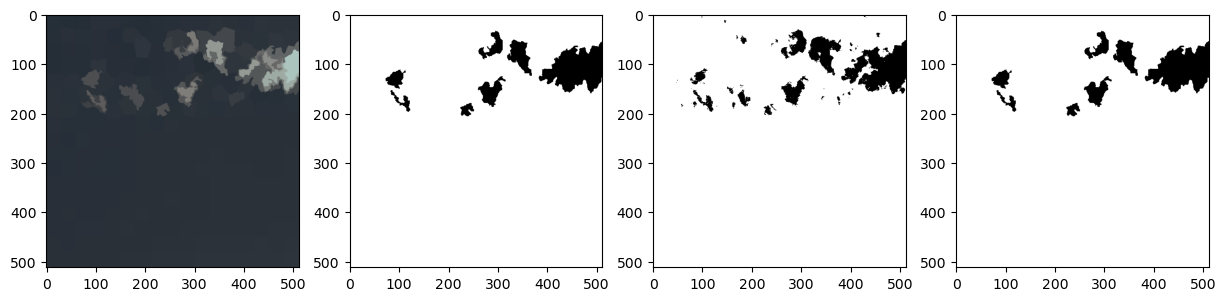

In [381]:
nu=0

seg,prop,lab,bin,slic_map=convert_image_array_to_slic_with_properties(image_array=true_patches[nu],binary_array=label_patches[nu],n_segments=300)
revseg=reverse_segmentation(slic_map,lab)

plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(seg)
plt.subplot(1,4,2)
plt.imshow(bin,cmap='gray')
plt.subplot(1,4,3)
plt.imshow(label_patches[nu],cmap='gray')
plt.subplot(1,4,4)
plt.imshow(revseg,cmap='gray')